# Using autoenconder for anomaly detection

### The [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) *creditcard* comes from kaggle.

The ideia is to feed only normal transactions to the autoencoder so it learns to reproduce the data with high fidelity. As a consequence, if a fraud transaction is distinct from the normal ones, the autoenconder will have trouble reproducing it and the subsequent reconstruction loss will be high.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

## Loading the dataset

In [2]:
path_to_data = os.getcwd().replace("\\", "/") + "/creditcard.csv"
credit_card_df = pd.read_csv(path_to_data)
credit_card_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Information about the dataset

In [3]:
print(f"This dataset has {credit_card_df.shape[0]} rows and {credit_card_df.shape[1]} columns")

This dataset has 284807 rows and 31 columns


In [4]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### No null values

In [5]:
null_values = credit_card_df.isnull().sum()
print(null_values[null_values > 0])

Series([], dtype: int64)


In [6]:
credit_card_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The columns are all upper case, let´s change it to lower case <br>
### also the column "Class" may cause problems so let´s change it to "label"

In [7]:
credit_card_df.columns = map(str.lower, credit_card_df.columns)
credit_card_df.rename(columns = {"class":"label"}, inplace = True)
credit_card_df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Turn the amount feature into a normally distributed log equivalent

In [8]:
credit_card_df["amount"] = np.log10(credit_card_df.amount + 0.00001)

## No need for time feature

In [ ]:
credit_card_df.drop(["time"], axis = 1, inplace = True)

## How many examples of fraud and non-fraud transactions the dataset has

In [9]:
credit_card_df.groupby("label").label.count()

label
0    284315
1       492
Name: label, dtype: int64

In [11]:
fraud = credit_card_df[credit_card_df.label == 1]
clean = credit_card_df[credit_card_df.label == 0]

## The training set will only have non-fraud transactions (label = 0)

### The test set needs to have non-fraud and fraud transactions

In [12]:
credit_card_df.shape

(284807, 30)

In [13]:
separation = 200000

In [14]:
X_train = clean.iloc[:separation].drop("label", axis = 1)

X_test = clean.iloc[separation:].append(fraud)

In [15]:
X_train, X_validate = train_test_split(X_train, test_size = 0.2, random_state = 42)

In [16]:
X_test, y_test = X_test.drop("label", axis = 1).values, X_test.label.values

In [17]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

Shape of the datasets:
    training (rows, cols) = (160000, 29)
    validate (rows, cols) = (40000, 29)
    holdout  (rows, cols) = (84807, 29)


## Preprocessing the features

In [18]:
pipeline = Pipeline([('normalizer', Normalizer()), ('scaler', MinMaxScaler())])
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_validate_transformed = pipeline.transform(X_validate)

## Training the autoenconder

In [19]:
input_shape = X_train_transformed.shape[1]

## Enconder
encoder_input = keras.layers.Input(shape = (input_shape,))
l = keras.layers.Dense(16, activation = "relu")(encoder_input)
l = keras.layers.Dense(8, activation = "relu")(l)
l = keras.layers.Dense(4, activation = "relu")(l)
encoder_output = keras.layers.Dense(2, activation = "relu", name = "bottleneck")(l)
## Decoder
decoder_input = keras.layers.Dense(4, activation = "relu")(encoder_output)
l = keras.layers.Dense(8, activation = "relu")(decoder_input)
l = keras.layers.Dense(16, activation = "relu")(l)
decoder_output = keras.layers.Dense(input_shape)(l)
## Autoencoder model
autoencoder = keras.Model(encoder_input, decoder_output, name = "autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 

In [20]:
autoencoder.compile(optimizer = "adam", loss = "mse")
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 10, restore_best_weights = True)
history = autoencoder.fit(X_train_transformed, X_train_transformed, 
        validation_data = (X_validate_transformed, X_validate_transformed), 
        epochs = 100, 
        batch_size = 256, 
        callbacks = [early_stop], shuffle = True)

Epoch 1/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0467 - val_loss: 0.0168
Epoch 2/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 3/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 4/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0166 - val_loss: 0.0166
Epoch 5/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0166 - val_loss: 0.0165
Epoch 6/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0165 - val_loss: 0.0164
Epoch 7/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0159
Epoch 8/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 9/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0151 - val_loss: 0.0150
Epoch 10/100
625/625 [==============================] - 1s 1ms/step - loss: 0.0149 - val_lo

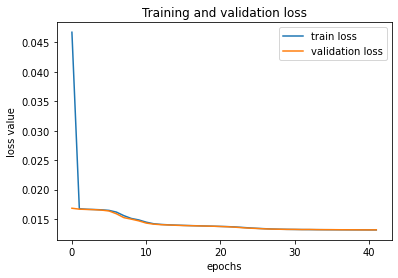

In [21]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df.loss, label="train loss")
plt.plot(history_df.val_loss, label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend(loc="best")
plt.show()

In [22]:
X_test_transformed = pipeline.transform(X_test)

reconstructions = autoencoder.predict(X_test_transformed)

c:\Users\Legion\Desktop\anomaly-detection-autoencoder\venv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  "X does not have valid feature names, but"


## Calculating the mean squared error reconstruction loss per row

In [23]:
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis = 1)

In [28]:
clean = mse[y_test == 0]
fraud = mse[y_test == 1]

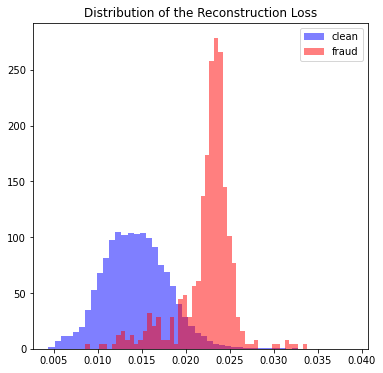

In [30]:
plt.figure(figsize = (6, 6))

plt.hist(clean, bins = 50, density = True, label = "clean", alpha = 0.5, color = "blue")
plt.hist(fraud, bins = 50, density = True, label = "fraud", alpha = 0.5, color = "red")

plt.title("Distribution of the Reconstruction Loss")
plt.legend()
plt.show()